In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateFormatter, AutoDateLocator
import seaborn as sns

from os.path import exists
# import gdown
# import zipfile
from datetime import datetime

## Data Loading, downsampling and manipulation

In [2]:
# Load times series csv file
# Each file contains data from approximately 50 devices
ts1_df = pd.read_csv('..\data/devices1.csv')
ts2_df = pd.read_csv('..\data/devices2.csv')
ts3_df = pd.read_csv('..\data/devices3.csv')
ts4_df = pd.read_csv('..\data/devices4.csv')
 # Concatenate into one big dataframe
ts_df = pd.concat([ts1_df, ts2_df, ts3_df, ts4_df], axis = 0, ignore_index = True)

Downsample the ts_df dataframe by removing rows that contain NaN values.

In [3]:
ts_df_lean = ts_df.dropna()

Add power column and abs(power) column

In [4]:
ts_df_lean["power"] = ts_df_lean["battery_voltage"]*ts_df_lean["current"]
ts_df_lean["abs(power)"] = ts_df_lean["power"].abs()

Convert timestamp to datetime format and add columns for 'year' and 'month'

In [5]:
# convert timestamp column to datetime format. It has useful functionality, such as getting the 'month' or 'year'
ts_df_lean["timestamp"] = pd.to_datetime(ts_df_lean["timestamp"])

In [6]:
# #Add year, and month as dataframe columns
# year = np.empty((len(ts_df_lean)), dtype=int)
# month = np.empty((len(ts_df_lean)), dtype=int)
# for i in range(len(ts_df_lean)):
#     year[i] = ts_df_lean["timestamp"].iloc[i].year
#     month[i] = ts_df_lean["timestamp"].iloc[i].month

In [7]:
# ts_df_lean["year"] = year
# ts_df_lean["month"] = month

Create two new time-related columns and add them to the dataframe.<br>
Column 'time_battery_sec' contains values which start at 0 for every battery, subsequently counting the operating time of the battery in seconds. <br>
Column 'dt_sec' gives the sampling time step. Will be useful later to calculate time-weighted averages. At the first row of every battery, dt is zero.

In [8]:
# Had to make some conversions back to string to get this to work.
# Some complications were due to numpy changing the format of datetime objects before storing them.
time_battery_sec = np.empty((0,1))
dt_sec = np.empty((0,1))
for battery in range(0,200):
    single_battery_df = ts_df_lean.loc[ts_df_lean['battery_id']==battery]
    # Get the starting timestamp of this battery. This will be time zero.
    # Also place in this more convenient datetime format which will allow subtraction of datetimes.
    datetime_0 = datetime.strptime(str(single_battery_df["timestamp"].iloc[0]), "%Y-%m-%d %H:%M:%S")
    # Initialise numpy array to store battery_time. Loops using pandas would be too slow.
    battery_time = single_battery_df["timestamp"].astype(str).to_numpy()
    for i, entry in enumerate(battery_time):
        datetime_1 = datetime.strptime(str(entry), "%Y-%m-%d %H:%M:%S")
        battery_time[i] = float((datetime_1-datetime_0).total_seconds())
    # Convert to float:
    battery_time = battery_time.astype(float)
    battery_dt = np.zeros((battery_time.shape[0],)) #Useful mostly because it puts a zero at the -1 index for this battery_id.
    battery_dt[0:-1] = battery_time[1:] - battery_time[0:-1]
    time_battery_sec = np.append(time_battery_sec, battery_time)
    dt_sec = np.append(dt_sec, battery_dt)

In [9]:
# Add new pandas Series to ts_df_lean
ts_df_lean["time_battery_sec"] = time_battery_sec
ts_df_lean["dt_sec"] = dt_sec

In [10]:
def binning(battery_id, df, bin_edges, param, statistic = 'mean', month = None):
    """
    For the provided 'battery_id', calculate the provided 'statistic' of the given parameter 'param'.
    E.g. param could be temperature or pressure.
    When the required statistic is the 'mean', calculate a time-weighted mean instead of a simple 
    mean to account for the duration of the conditions being averaged.
    """
    filter = (df["battery_id"]==battery_id)
    if month != None:
        filter = filter & (df["month"]==month)
    local_df = df.loc[filter]
    output = np.empty(len(bin_edges)-1)
    output[:] = np.NaN
    for i, edge1 in enumerate(bin_edges[:-1]):
        edge2 = bin_edges[i+1]
        bin_filter = df["state_of_charge_percent"].between(edge1, edge2, inclusive = 'left')
        bin_df = local_df.loc[bin_filter]        
        if statistic == 'max':
            calc = bin_df[param].quantile(q=0.99) #Avoid doing .max() to avoid picking outliers.
        elif statistic == 'min':
            calc = bin_df[param].quantile(q=0.01) #Avoid doing .min() to avoid picking outliers.
        elif statistic == 'mean':
            #In this case get a weighter average.
            sum_of_bin_dts = bin_df["dt_sec"].sum()
            time_weighted_bin_param = bin_df[param] * bin_df["dt_sec"]
            sum_of_time_weighted_bin_param = time_weighted_bin_param.sum()
            if sum_of_bin_dts == 0:
                calc = np.NaN
            else:
                calc = sum_of_time_weighted_bin_param / sum_of_bin_dts
        output[i]=calc
    return(output)

In [11]:
soc_bin_edges = list(range(0,150,20))
n_bins = len(soc_bin_edges)-1

Create temperature and power features at SoC bins

In [12]:
#Columns 0-14 will contain the mean values
#Columns 15-29 will contain the max values
#Columns 30-44 will contain the min values
temp_features = np.empty((200,n_bins*3))
temp_features[:] = np.NaN
for battery in range(200):
    calc = binning(battery, ts_df_lean, soc_bin_edges, param='temperature', statistic = 'mean')
    temp_features[battery,0:n_bins] = calc
    calc = binning(battery, ts_df_lean, soc_bin_edges, param='temperature', statistic = 'max')
    temp_features[battery,n_bins:2*n_bins] = calc
    calc = binning(battery, ts_df_lean, soc_bin_edges, param='temperature', statistic = 'min')
    temp_features[battery, 2*n_bins:3*n_bins] = calc

In [13]:
#Columns 0-14 will contain the mean values of the absolute power
#Columns 15-29 will contain the max values of the power (i.e. this will be the maximum of the discharging power)
#Columns 30-44 will contain the min values of the power (i.e. this will be the maximum of the charging power)
power_features = np.empty((200,n_bins*3))
power_features[:] = np.NaN

for battery in range(200):
    calc = binning(battery, ts_df_lean, soc_bin_edges, param='abs(power)', statistic = 'mean')
    power_features[battery, 0:n_bins] = calc
    calc = binning(battery, ts_df_lean, soc_bin_edges, param='power', statistic = 'max')
    power_features[battery, n_bins:2*n_bins] = calc
    calc = binning(battery, ts_df_lean, soc_bin_edges, param='power', statistic = 'min')
    power_features[battery, 2*n_bins:3*n_bins] = calc

In [14]:
# Create bin names to use as columns of temperature and power dataframes
temp_columns = []
for statistic in ['mean', 'max', 'min']:
    for i in range(n_bins):
        bin_edge_left = soc_bin_edges[i]
        bin_edge_right = soc_bin_edges[i+1]
        temp_var_name = '%s-%sSoc_T%s'%(bin_edge_left, bin_edge_right, statistic)
        temp_columns.append(temp_var_name)
power_columns = []
for statistic in ['mean(abs)', 'max', 'min']:
    for i in range(n_bins):
        bin_edge_left = soc_bin_edges[i]
        bin_edge_right = soc_bin_edges[i+1]
        power_var_name = '%s-%sSoc_P%s'%(bin_edge_left, bin_edge_right, statistic)
        power_columns.append(power_var_name)

In [15]:
df_temp_features = pd.DataFrame(temp_features, columns=temp_columns)
df_power_features = pd.DataFrame(power_features, columns=power_columns)
# Take care of NaN values
temp_means = df_temp_features.mean()
df_temp_features = df_temp_features.fillna(temp_means, axis = 0)
power_means = df_power_features.mean()
df_power_features = df_power_features.fillna(power_means, axis = 0)

Text(0.5, 1.0, 'Mean temperature heatmap')

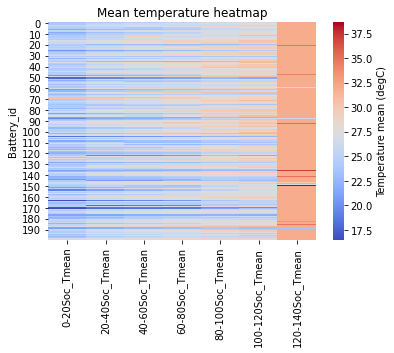

In [16]:
ax = sns.heatmap(df_temp_features.iloc[:,:n_bins], annot=False, cmap='coolwarm',cbar_kws={'label': 'Temperature mean (degC)'})
ax.set_ylabel('Battery_id')
plt.title('Mean temperature heatmap')

Text(0.5, 1.0, 'Max temperature (99th percentile) heatmap')

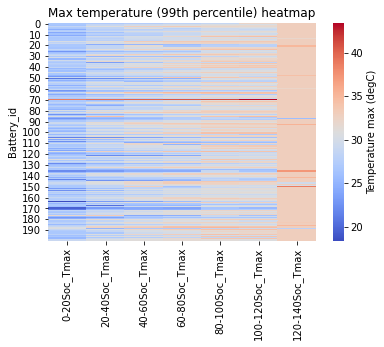

In [17]:
ax = sns.heatmap(df_temp_features.iloc[:,n_bins:2*n_bins], annot=False, cmap='coolwarm',cbar_kws={'label': 'Temperature max (degC)'})
ax.set_ylabel('Battery_id')
plt.title('Max temperature (99th percentile) heatmap')

Text(0.5, 1.0, 'Min temperature (1st percentile) heatmap')

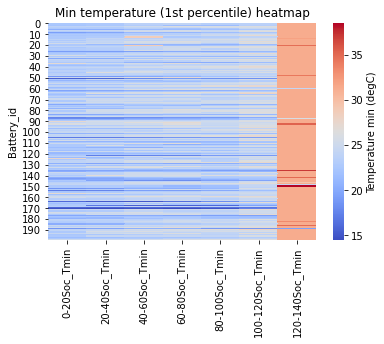

In [18]:
ax = sns.heatmap(df_temp_features.iloc[:,2*n_bins:3*n_bins], annot=False, cmap='coolwarm',cbar_kws={'label': 'Temperature min (degC)'})
ax.set_ylabel('Battery_id')
plt.title('Min temperature (1st percentile) heatmap')

Text(0.5, 1.0, 'Temperature Features')

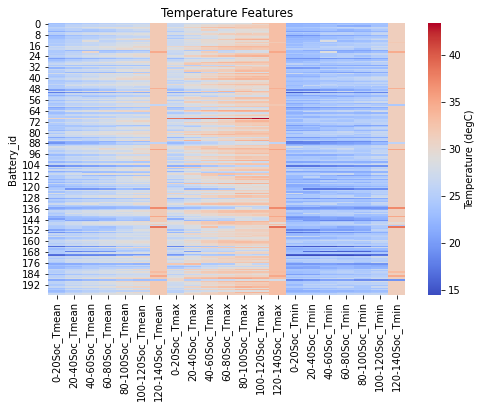

In [19]:
f, ax = plt.subplots(figsize=(8,5))
ax = sns.heatmap(df_temp_features, annot=False, cmap='coolwarm',cbar_kws={'label': 'Temperature (degC)'})
ax.set_ylabel('Battery_id')
plt.title('Temperature Features')

Text(0.5, 1.0, 'Mean absolute power heatmap')

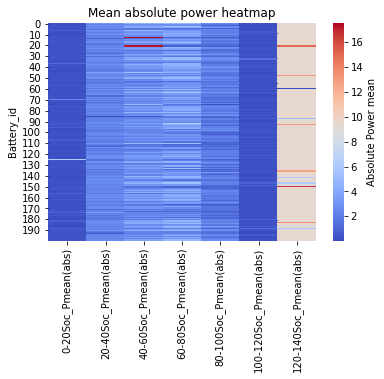

In [20]:
ax = sns.heatmap(df_power_features.iloc[:,:n_bins], annot=False, cmap='coolwarm',cbar_kws={'label': 'Absolute Power mean'})
ax.set_ylabel('Battery_id')
plt.title('Mean absolute power heatmap')

Text(0.5, 1.0, 'Max power (99th percentile) heatmap')

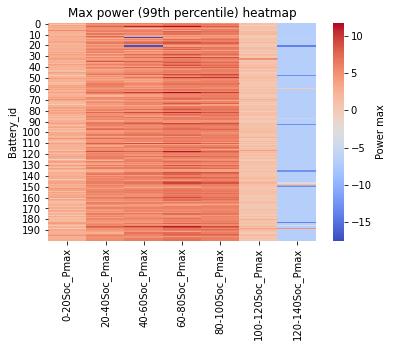

In [21]:
ax = sns.heatmap(df_power_features.iloc[:,n_bins:2*n_bins], annot=False, cmap='coolwarm',cbar_kws={'label': 'Power max'})
ax.set_ylabel('Battery_id')
plt.title('Max power (99th percentile) heatmap')

Text(0.5, 1.0, 'Min power (1st percentile) heatmap')

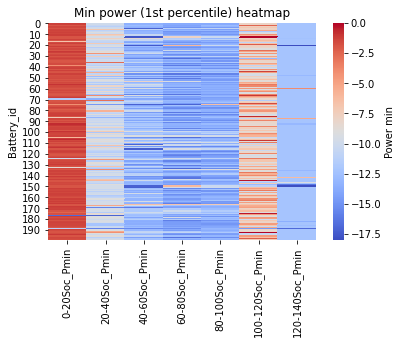

In [22]:
ax = sns.heatmap(df_power_features.iloc[:,2*n_bins:3*n_bins], annot=False, cmap='coolwarm',cbar_kws={'label': 'Power min'})
ax.set_ylabel('Battery_id')
plt.title('Min power (1st percentile) heatmap')

Text(0.5, 1.0, 'Power Features')

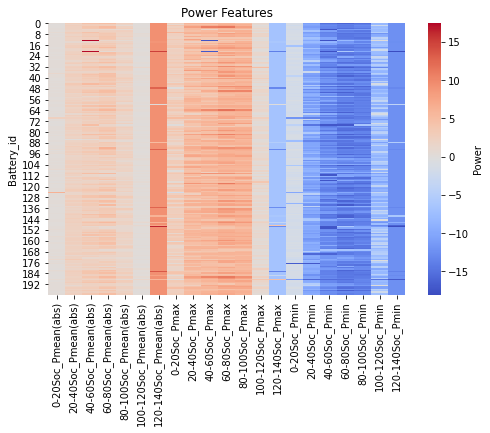

In [23]:
f, ax = plt.subplots(figsize=(8,5))
ax = sns.heatmap(df_power_features, annot=False, cmap='coolwarm',cbar_kws={'label': 'Power'})
ax.set_ylabel('Battery_id')
plt.title('Power Features')

In [24]:
df_all_features = pd.concat([df_temp_features, df_power_features], axis=1)

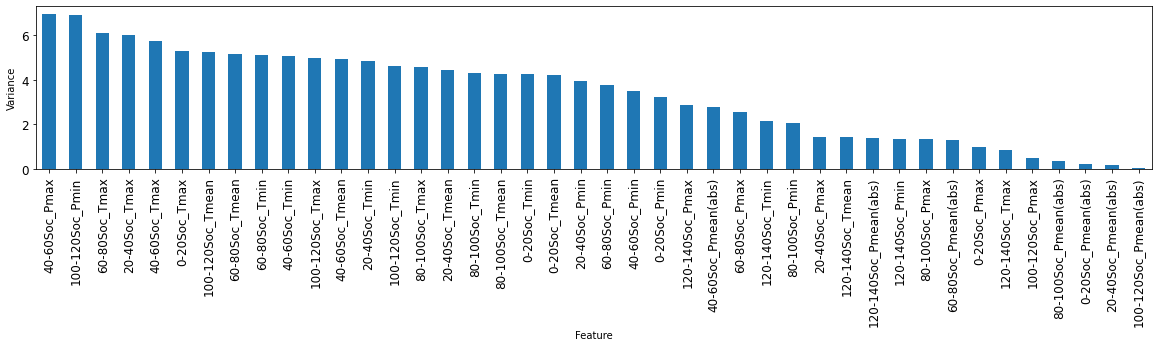

In [25]:
#For information, features ranked by variance.
variances = df_all_features.var().sort_values(ascending=False)
f, ax = plt.subplots(figsize=(20,3))
ax = variances.iloc[:60].plot.bar()
ax.set_xlabel('Feature')
ax.set_ylabel('Variance')
ax.tick_params(labelsize=12)

## PCA and clustering

Three different feature datasets will be considered to do PCA.
1) Only the temperature features.
2) Only the power features.
3) All features.
After this data exploration, it was decided to use the 3rd PCA (PCA on all features) to do clustering.

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Standardise the features to zero mean and unit variance.
st_temp_features =  StandardScaler().fit_transform(df_temp_features) # Returns ndarray
st_power_features =  StandardScaler().fit_transform(df_power_features) # Returns ndarray
st_all_features =  StandardScaler().fit_transform(df_all_features) # Returns ndarray
pca_temp = PCA(n_components=10).fit(st_temp_features)
pca_power = PCA(n_components=10).fit(st_power_features)
pca_all = PCA(n_components=10).fit(st_all_features)


In [27]:
# component loadings (correlation coefficient between original variables and the PCA component) 
# From sklearn:
# components_ndarray of shape (n_components, n_features)
# Principal axes in feature space, representing the directions of maximum variance in the data.
# The components are sorted by explained_variance_.
pca_temp_loadings = pca_temp.components_
pca_power_loadings = pca_power.components_
pca_all_loadings = pca_all.components_
num_pc_temp = pca_temp.n_features_
num_pc_power = pca_power.n_features_
num_pc_all = pca_all.n_features_

In [28]:
# Re Temperature PCA
pc_temp_list = ["PC"+str(i) for i in list(range(1, num_pc_temp+1))]
df_temp_loadings = pd.DataFrame.from_dict(dict(zip(pc_temp_list, pca_temp_loadings)))
df_temp_loadings['variable'] = df_temp_features.columns.values
df_temp_loadings = df_temp_loadings.set_index('variable')
# Re Power PCA
pc_power_list = ["PC"+str(i) for i in list(range(1, num_pc_power+1))]
df_power_loadings = pd.DataFrame.from_dict(dict(zip(pc_power_list, pca_power_loadings)))
df_power_loadings['variable'] = df_power_features.columns.values
df_power_loadings = df_power_loadings.set_index('variable')
# Re 'All' PCA
pc_all_list = ["PC"+str(i) for i in list(range(1, num_pc_all+1))]
df_all_loadings = pd.DataFrame.from_dict(dict(zip(pc_all_list, pca_all_loadings)))
df_all_loadings['variable'] = df_all_features.columns.values
df_all_loadings = df_all_loadings.set_index('variable')

Text(0, 0.5, 'Proportion of variance (%)')

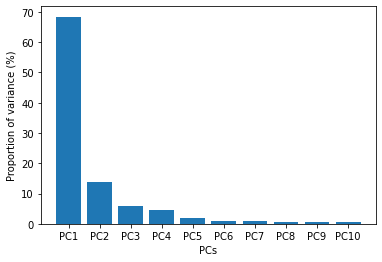

In [29]:
# Re Temperature PCA
num_PCs=10
plt.bar(pc_temp_list[:num_PCs], height = pca_temp.explained_variance_ratio_[:num_PCs]*100)
plt.xlabel('PCs')
plt.ylabel('Proportion of variance (%)')

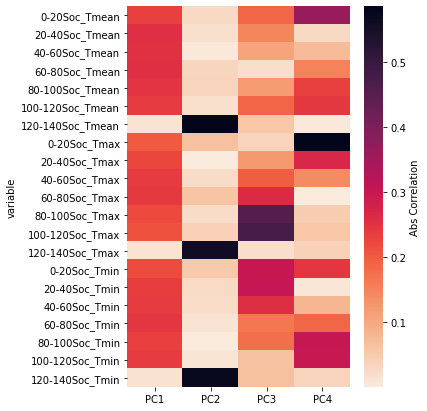

In [30]:
# Re Temperature PCA
num_PCs = 4
f, ax = plt.subplots(figsize=(5,7))
ax = sns.heatmap(df_temp_loadings.iloc[:, :num_PCs].abs(), annot=False, cmap='rocket_r', cbar_kws={'label': 'Abs Correlation'})
ax.set_ylabel('variable')
plt.show()

Text(0, 0.5, 'PC2')

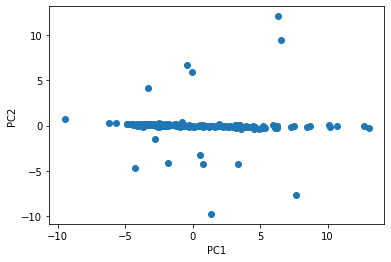

In [31]:
# Re Temperature PCA
pca_temp_scores = PCA().fit_transform(st_temp_features)
pca_temp_scores
#2D plot
PC1 = pca_temp_scores[:,0]
PC2 = pca_temp_scores[:,1]
plt.scatter(PC1, PC2)
plt.xlabel("PC1")
plt.ylabel("PC2")

Text(0.5, 0, 'PC3')

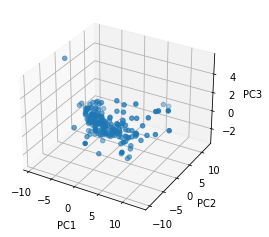

In [32]:
# Re Temperature PCA
# 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs = pca_temp_scores[:,0]
ys = pca_temp_scores[:,1]
zs = pca_temp_scores[:,2]
ax.scatter(xs, ys, zs)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

Text(0, 0.5, 'Proportion of variance (%)')

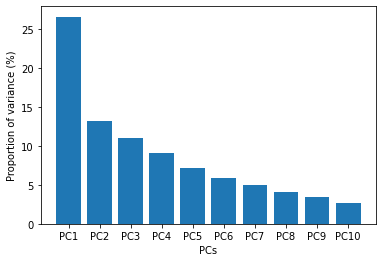

In [33]:
# Re Power PCA
num_PCs=10
plt.bar(pc_power_list[:num_PCs], height = pca_power.explained_variance_ratio_[:num_PCs]*100)
plt.xlabel('PCs')
plt.ylabel('Proportion of variance (%)')

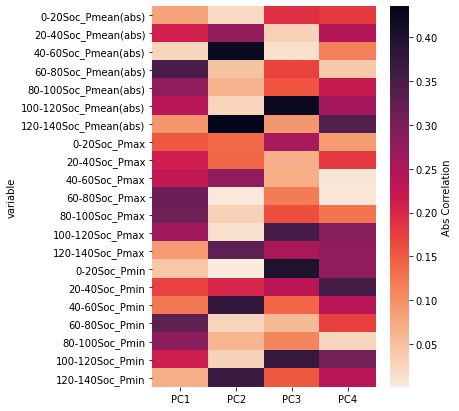

In [34]:
# Re Power PCA
num_PCs = 4
f, ax = plt.subplots(figsize=(5,7))
ax = sns.heatmap(df_power_loadings.iloc[:, :num_PCs].abs(), annot=False, cmap='rocket_r', cbar_kws={'label': 'Abs Correlation'})
ax.set_ylabel('variable')
plt.show()

Text(0, 0.5, 'PC2')

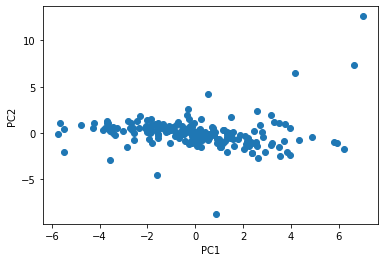

In [35]:
# Re Power PCA
pca_power_scores = PCA().fit_transform(st_power_features)
pca_power_scores
#2D plot
PC1 = pca_power_scores[:,0]
PC2 = pca_power_scores[:,1]
plt.scatter(PC1, PC2)
plt.xlabel("PC1")
plt.ylabel("PC2")

Text(0.5, 0, 'PC3')

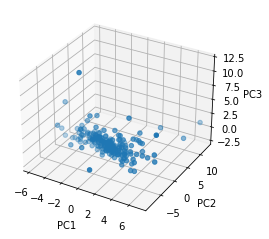

In [36]:
# Re Power PCA
# 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs = pca_power_scores[:,0]
ys = pca_power_scores[:,1]
zs = pca_power_scores[:,2]
ax.scatter(xs, ys, zs)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

Text(0, 0.5, 'Explained variance (%)')

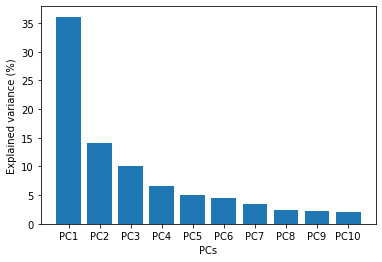

In [37]:
# Re 'All' PCA
num_PCs=10
plt.bar(pc_all_list[:num_PCs], height = pca_all.explained_variance_ratio_[:num_PCs]*100)
plt.xlabel('PCs')
plt.ylabel('Explained variance (%)')

In [38]:
df_all_loadings.shape

(42, 10)

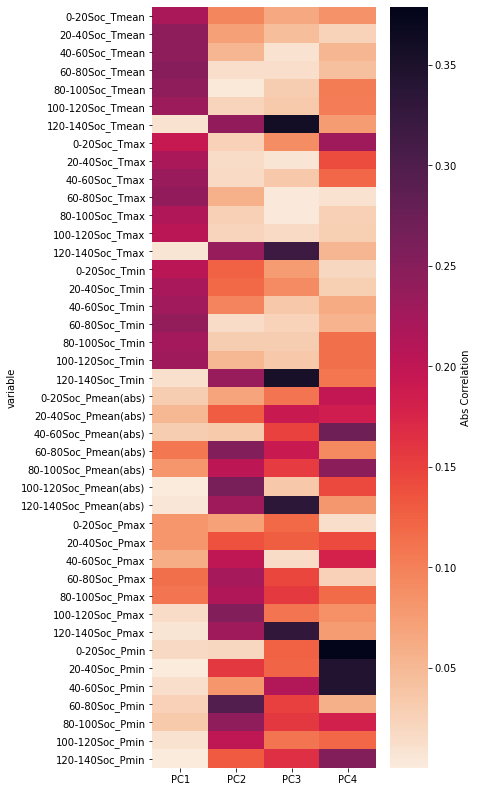

In [39]:
# Re 'All' PCA
num_PCs = 4
f, ax = plt.subplots(figsize=(5,14))
ax = sns.heatmap(df_all_loadings.iloc[:, :num_PCs].abs(), annot=False, cmap='rocket_r', cbar_kws={'label': 'Abs Correlation'})
ax.set_ylabel('variable')
plt.show()

Text(0, 0.5, 'PC2')

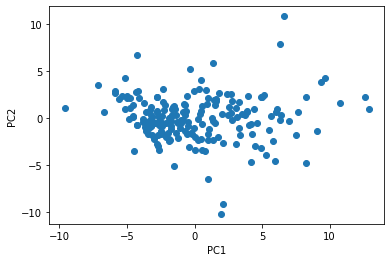

In [40]:
# Re 'All' PCA
pca_all_scores = PCA().fit_transform(st_all_features)
pca_all_scores
#2D plot
PC1 = pca_all_scores[:,0]
PC2 = pca_all_scores[:,1]
plt.scatter(PC1, PC2)
plt.xlabel("PC1")
plt.ylabel("PC2")

Text(0, 0.5, 'PC3')

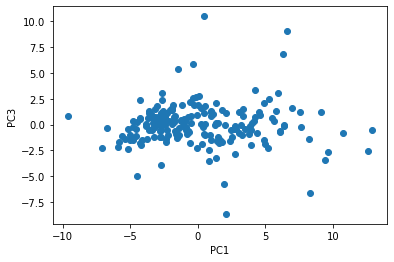

In [41]:
# Re 'All' PCA
pca_all_scores = PCA().fit_transform(st_all_features)
pca_all_scores
#2D plot
PC1 = pca_all_scores[:,0]
PC2 = pca_all_scores[:,2]
plt.scatter(PC1, PC2)
plt.xlabel("PC1")
plt.ylabel("PC3")

Text(0, 0.5, 'PC3')

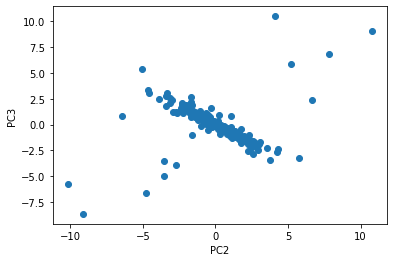

In [42]:
# Re 'All' PCA
pca_all_scores = PCA().fit_transform(st_all_features)
pca_all_scores
#2D plot
PC1 = pca_all_scores[:,1]
PC2 = pca_all_scores[:,2]
plt.scatter(PC1, PC2)
plt.xlabel("PC2")
plt.ylabel("PC3")

Text(0.5, 0, 'PC3')

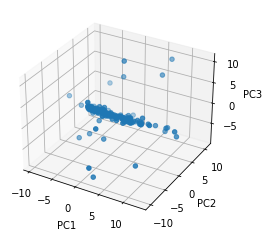

In [43]:
# Re 'All' PCA
# 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs = pca_all_scores[:,0]
ys = pca_all_scores[:,1]
zs = pca_all_scores[:,2]
ax.scatter(xs, ys, zs)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

## Clustering using the PCA performed on all features (i.e. 21 power features + 21 temperature features)

In [44]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
estimator = KMeans(n_clusters=4, random_state=0)
estimator.fit(pca_all_scores[:,:2])
labels = estimator.labels_

In [45]:
norm = matplotlib.colors.Normalize(vmin=labels.min(), vmax=labels.max())
cmap = cm.Set2
m = cm.ScalarMappable(norm=norm, cmap=cmap)
c=list(labels.astype(float))
for i, colour in enumerate(c):
    c[i] = cm.Set2(colour) #Using the same in seaborn later
    c[i] = m.to_rgba(colour)

Text(0, 0.5, 'PC2\n(14.0 % of data variance)')

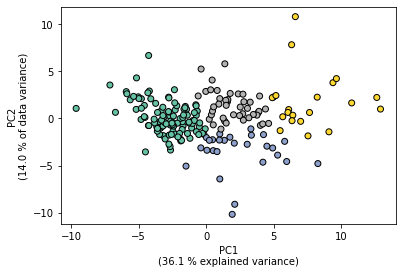

In [46]:
f, ax = plt.subplots()
x = pca_all_scores[:,0]
y = pca_all_scores[:,1]
ax.scatter(x, y, c=c, edgecolor="k")
ax.set_xlabel("PC1\n({:.1f} % explained variance)".format(pca_all.explained_variance_ratio_[0]*100))
ax.set_ylabel("PC2\n({:.1f} % of data variance)".format(pca_all.explained_variance_ratio_[1]*100))

Text(0, 0.5, 'PC3\n(10.0 % of data variance)')

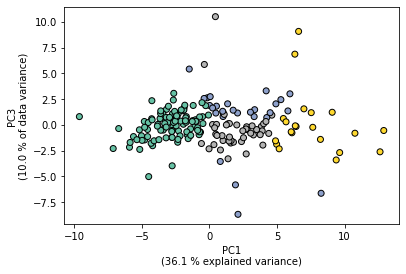

In [47]:
f, ax = plt.subplots()
x = pca_all_scores[:,0]
y = pca_all_scores[:,2]
ax.scatter(x, y, c=c, edgecolor="k")
ax.set_xlabel("PC1\n({:.1f} % explained variance)".format(pca_all.explained_variance_ratio_[0]*100))
ax.set_ylabel("PC3\n({:.1f} % of data variance)".format(pca_all.explained_variance_ratio_[2]*100))

Text(0, 0.5, 'PC3\n(10.0 % of data variance)')

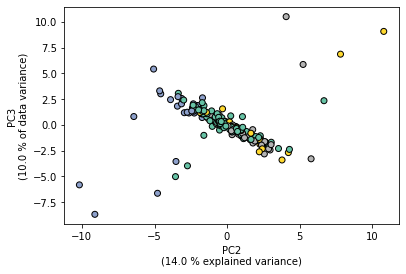

In [48]:
f, ax = plt.subplots()
x = pca_all_scores[:,1]
y = pca_all_scores[:,2]
ax.scatter(x, y, c=c, edgecolor="k")
ax.set_xlabel("PC2\n({:.1f} % explained variance)".format(pca_all.explained_variance_ratio_[1]*100))
ax.set_ylabel("PC3\n({:.1f} % of data variance)".format(pca_all.explained_variance_ratio_[2]*100))

Text(0.5, 0, 'PC3')

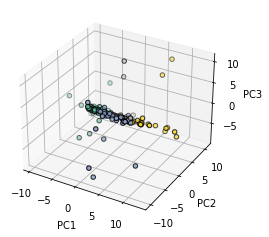

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs = pca_all_scores[:,0]
ys = pca_all_scores[:,1]
zs = pca_all_scores[:,2]
ax.scatter(xs, ys, zs, c=c, edgecolor="k")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

In [50]:
df_temp_features_clustered = pd.DataFrame.copy(df_temp_features)
df_temp_features_clustered["cluster"] = labels
df_power_features_clustered = pd.DataFrame.copy(df_power_features)
df_power_features_clustered["cluster"] = labels
df_all_features_clustered = pd.DataFrame.copy(df_all_features)
df_all_features_clustered["cluster"] = labels

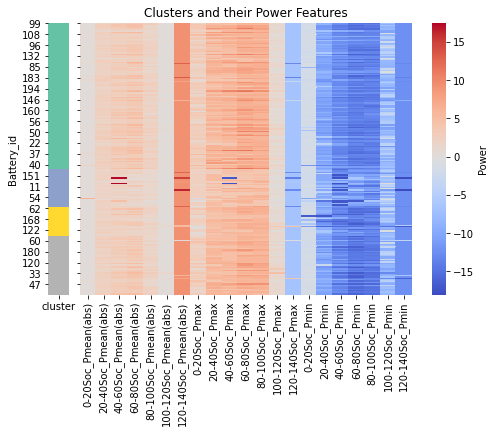

In [54]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(8,5),sharey=True, gridspec_kw={'width_ratios': [1, 20]})
plt.subplots_adjust(wspace=0.05)
g1 = sns.heatmap(df_power_features_clustered.sort_values('cluster').iloc[:,-1:], annot=False, cmap='Set2', ax=ax1, cbar=False)
g2 = sns.heatmap(df_power_features_clustered.sort_values('cluster').iloc[:,:-1], annot=False, cmap='coolwarm',cbar_kws={'label': 'Power'}, ax=ax2)
ax1.set_ylabel('Battery_id')
ax2.set_title('Clusters and their Power Features')

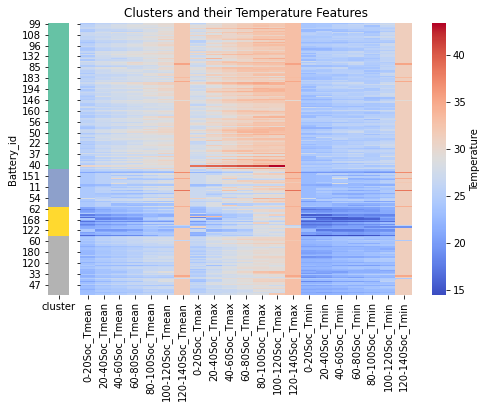

In [55]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(8,5),sharey=True, gridspec_kw={'width_ratios': [1, 20]})
plt.subplots_adjust(wspace=0.05)
g1 = sns.heatmap(df_temp_features_clustered.sort_values('cluster').iloc[:,-1:], annot=False, cmap='Set2', ax=ax1, cbar=False)
g2 = sns.heatmap(df_temp_features_clustered.sort_values('cluster').iloc[:,:-1], annot=False, cmap='coolwarm',cbar_kws={'label': 'Temperature'}, ax=ax2)
ax1.set_ylabel('Battery_id')
ax2.set_title('Clusters and their Temperature Features')